Modele autoregressif vectoriel après désaisonnalisation avec un GAM et 10 noeuds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
%run Eval_fcts.py
%run Standardize_fcts.py

# Fonctions

In [5]:
%run Regression_GAM_Gamma.py
%run Regression_VAR.py

/home/wendong/miniconda3/envs/geo/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Selection de modele

### AIC/BIC

In [5]:
n_knots = 10

aic_scores = []
bic_scores = []
for curr_p in tqdm(range(1, 16)):
    spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X, liste_stations, n_knots)
    mesures_train_X_residus = fct_Regression_SplineGamma_residus(spline_fit, mesures_train_X, liste_stations)
    model_VAR = VAR(mesures_train_X_residus[liste_stations])
    fit_VAR = model_VAR.fit(curr_p)
    
    aic_scores.append(fit_VAR.aic)
    bic_scores.append(fit_VAR.bic)
scores = pd.DataFrame({"Lag": range(1, 16), "AIC": aic_scores, "BIC": bic_scores})
scores

100%|██████████| 15/15 [00:55<00:00,  3.71s/it]


,Lag,AIC,BIC
0,1,111.501838,112.694480
1,2,101.999609,104.341259
2,3,100.579115,104.070300
3,4,100.069141,104.710391
4,5,99.932094,105.723937
5,6,99.880705,106.823672
6,7,99.895046,107.989665
7,8,99.953015,109.199818
8,9,100.005336,110.404852
9,10,100.112134,111.664895


In [6]:
scores.to_csv("../Data/GAMGamma_VAR/AIC_BIC_scores.csv",
              index=False)

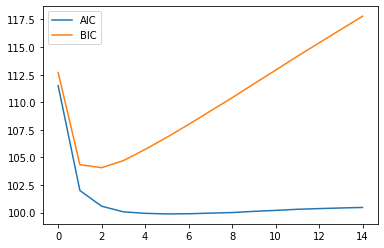

In [7]:
plt.plot(scores["AIC"], label = "AIC")
plt.plot(scores["BIC"], label = "BIC")
plt.legend()

# Validation croisée

In [8]:
n_knots = 10

In [9]:
for curr_p in tqdm(range(1,8)):
    cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations})
    cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations})
    cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations})
    
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        curr_train_X_mean = curr_train_X[liste_stations].mean()
        for code in liste_stations:
            curr_train_X_mean[code] = 0
        curr_train_X_std = curr_train_X[liste_stations].std()
        curr_train_X_standard = fct_Standardize(curr_train_X, 
                                                curr_train_X_mean, curr_train_X_std, 
                                                liste_stations)
        curr_train_X_standard["Date"] = curr_train_X["Date"].values
        spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations, n_knots)

        mesures_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                               curr_train_X_standard, 
                                                                               liste_stations)
        model_VAR = VAR(mesures_train_X_standard_residus[liste_stations])
        fit_VAR = model_VAR.fit(curr_p)

        # Prédictions
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
            # Predictions standard
        curr_test_X_standard = fct_Standardize(curr_test_X, 
                                                curr_train_X_mean, curr_train_X_std, 
                                                liste_stations)
        curr_test_X_standard["Date"] = curr_test_X["Date"].values
        curr_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, 
                                                                          curr_test_X_standard, 
                                                                          liste_stations)
        predictions_Y_standard_residus = fct_Regression_VAR_predict(curr_test_X_standard_residus, 
                                                                    fit_VAR, curr_p, liste_dates, liste_stations)
        # On rajoute la compo saisonnalité
        predictions_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
        predictions_Y_standard = predictions_Y_standard_residus[["Date"]].copy()
        for code in liste_stations:
            predictions_Y_standard[code] = predictions_Y_standard_residus[code].values + predictions_Y_standard_saisonnalite[code].values
            
        # Score
            # Score standard
        curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                curr_train_X_std, liste_stations)
        curr_test_Y_standard["Date"] = curr_test_Y["Date"].values
        curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
            # Score
        predictions_Y = fct_StandardizeInverse(predictions_Y_standard, curr_train_X_mean,
                                              curr_train_X_std, liste_stations)
        predictions_Y["Date"] = predictions_Y_standard["Date"].values
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]

    cv_moyen_RMSE_standard = []
    cv_moyen_MAE_standard = []
    cv_moyen_R2_standard = []
    
    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations:
        score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE_standard.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE_standard.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2_standard.append(score_R2)
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
    cv_scores_RMSE_standard.to_csv("../Data/GAMGamma_VAR/CV_RMSE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
    cv_scores_MAE_standard.to_csv("../Data/GAMGamma_VAR/CV_MAE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
    cv_scores_R2_standard.to_csv("../Data/GAMGamma_VAR/CV_R2_standard_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/GAMGamma_VAR/CV_RMSE_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/GAMGamma_VAR/CV_MAE_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/GAMGamma_VAR/CV_R2_p_" + str(curr_p).rjust(2, "0") + ".csv",
                          index=False)

100%|██████████| 7/7 [05:51<00:00, 50.14s/it]


### Selection modele

In [10]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


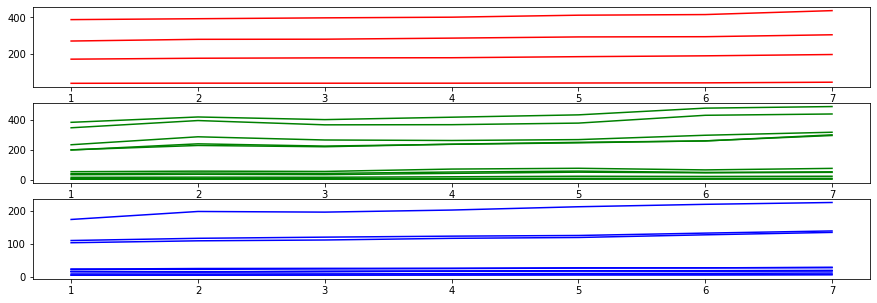

In [11]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_RMSE_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

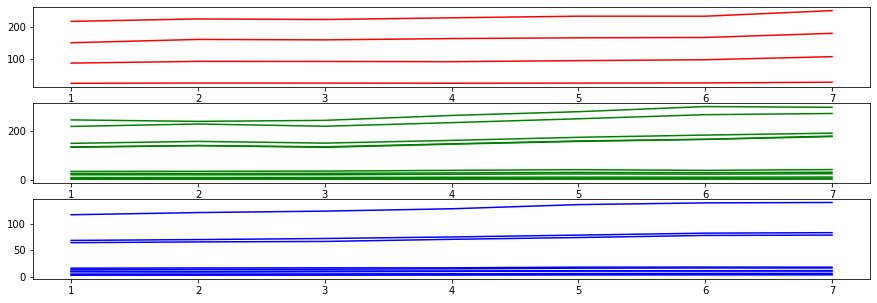

In [12]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_MAE_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

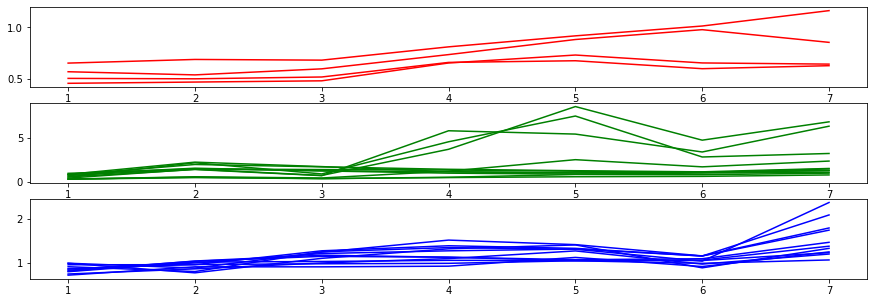

In [13]:
cv_moyen = pd.DataFrame()

for curr_p in range(1, 8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_R2_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lag"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lag"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Standard

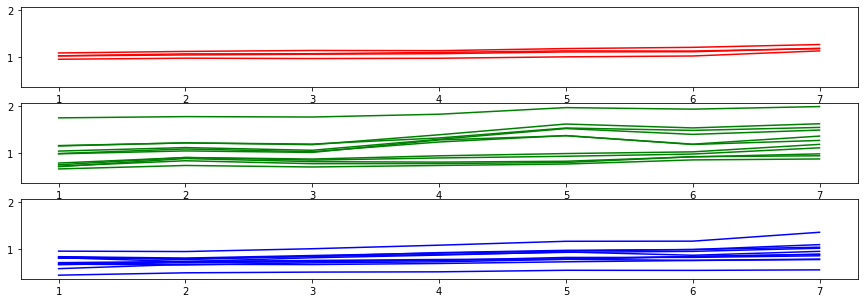

In [14]:
cv_moyen = pd.DataFrame()

for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_RMSE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lags"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

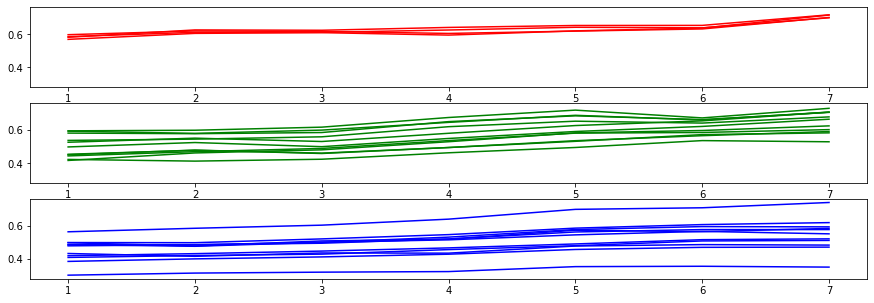

In [15]:
cv_moyen = pd.DataFrame()

for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_MAE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lags"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

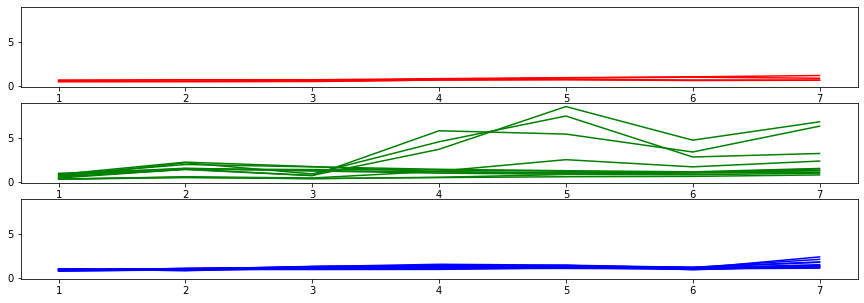

In [16]:
cv_moyen = pd.DataFrame()

for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_R2_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Lags"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

# Moyen

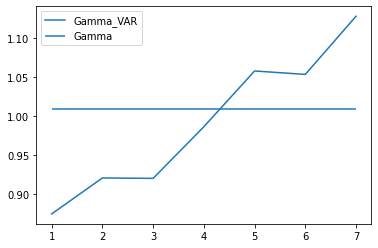

In [17]:
cv_moyen_Gamma = pd.read_csv("../Data/GAM_Gamma/CV_RMSE_standard_knots_" + str(n_knots).rjust(2, "0") + ".csv")["Moyenne"].mean()

cv_moyen = pd.DataFrame()
for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_RMSE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.hlines(y = cv_moyen_Gamma, xmin = 1, xmax = 7, label = "Gamma")
plt.plot(cv_moyen["Lags"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma_VAR")
plt.legend()

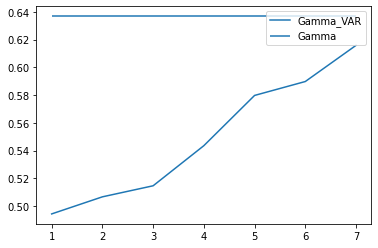

In [18]:
cv_moyen_Gamma = pd.read_csv("../Data/GAM_Gamma/CV_MAE_standard_knots_" + str(n_knots).rjust(2, "0") + ".csv")["Moyenne"].mean()

cv_moyen = pd.DataFrame()
for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_MAE_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.hlines(y = cv_moyen_Gamma, xmin = 1, xmax = 7, label = "Gamma")
plt.plot(cv_moyen["Lags"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma_VAR")
plt.legend()

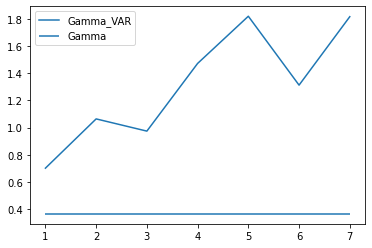

In [19]:
cv_moyen_Gamma = pd.read_csv("../Data/GAM_Gamma/CV_R2_standard_knots_" + str(n_knots).rjust(2, "0") + ".csv")["Moyenne"].mean()

cv_moyen = pd.DataFrame()
for curr_p in range(1,8):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAMGamma_VAR/CV_R2_standard_p_" + str(curr_p).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Lags"] = curr_p
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.hlines(y = cv_moyen_Gamma, xmin = 1, xmax = 7, label = "Gamma")
plt.plot(cv_moyen["Lags"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma_VAR")
plt.legend()

# Test

In [10]:
p = 2
n_knots = 10
curr_p=2

In [11]:
# Entrainement
    # Train Standard
mesures_train_X_mean = mesures_train_X[liste_stations].mean()
for code in liste_stations:
            mesures_train_X_mean[code] = 0
mesures_train_X_std = mesures_train_X[liste_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, mesures_train_X_mean,
                                                mesures_train_X_std, liste_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]
    #Spline Fit
spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X_standard, liste_stations, n_knots)
    # Train_X résidus
mesures_train_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, mesures_train_X_standard, liste_stations)
model_VAR = VAR(mesures_train_X_standard_residus[liste_stations])
fit_VAR = model_VAR.fit(p)

# Prédictions
liste_dates = mesures_test_Y["Date"]
    # Test_X standard et résidus
mesures_test_X_standard = fct_Standardize(mesures_test_X,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"]
mesures_test_X_standard_residus = fct_Regression_SplineGamma_residus(spline_fit, mesures_test_X_standard, liste_stations)
    # Predictions
predictions_test_Y_standard_residus = fct_Regression_VAR_predict(mesures_test_X_standard_residus, fit_VAR, curr_p, liste_dates, liste_stations)
# On rajoute la compo saisonnalité
predictions_test_Y_standard_saisonnalite = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)
predictions_test_Y_standard = predictions_test_Y_standard_residus[["Date"]].copy()
for code in liste_stations:
    predictions_test_Y_standard[code] = predictions_test_Y_standard_residus[code].values + predictions_test_Y_standard_saisonnalite[code].values

In [12]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

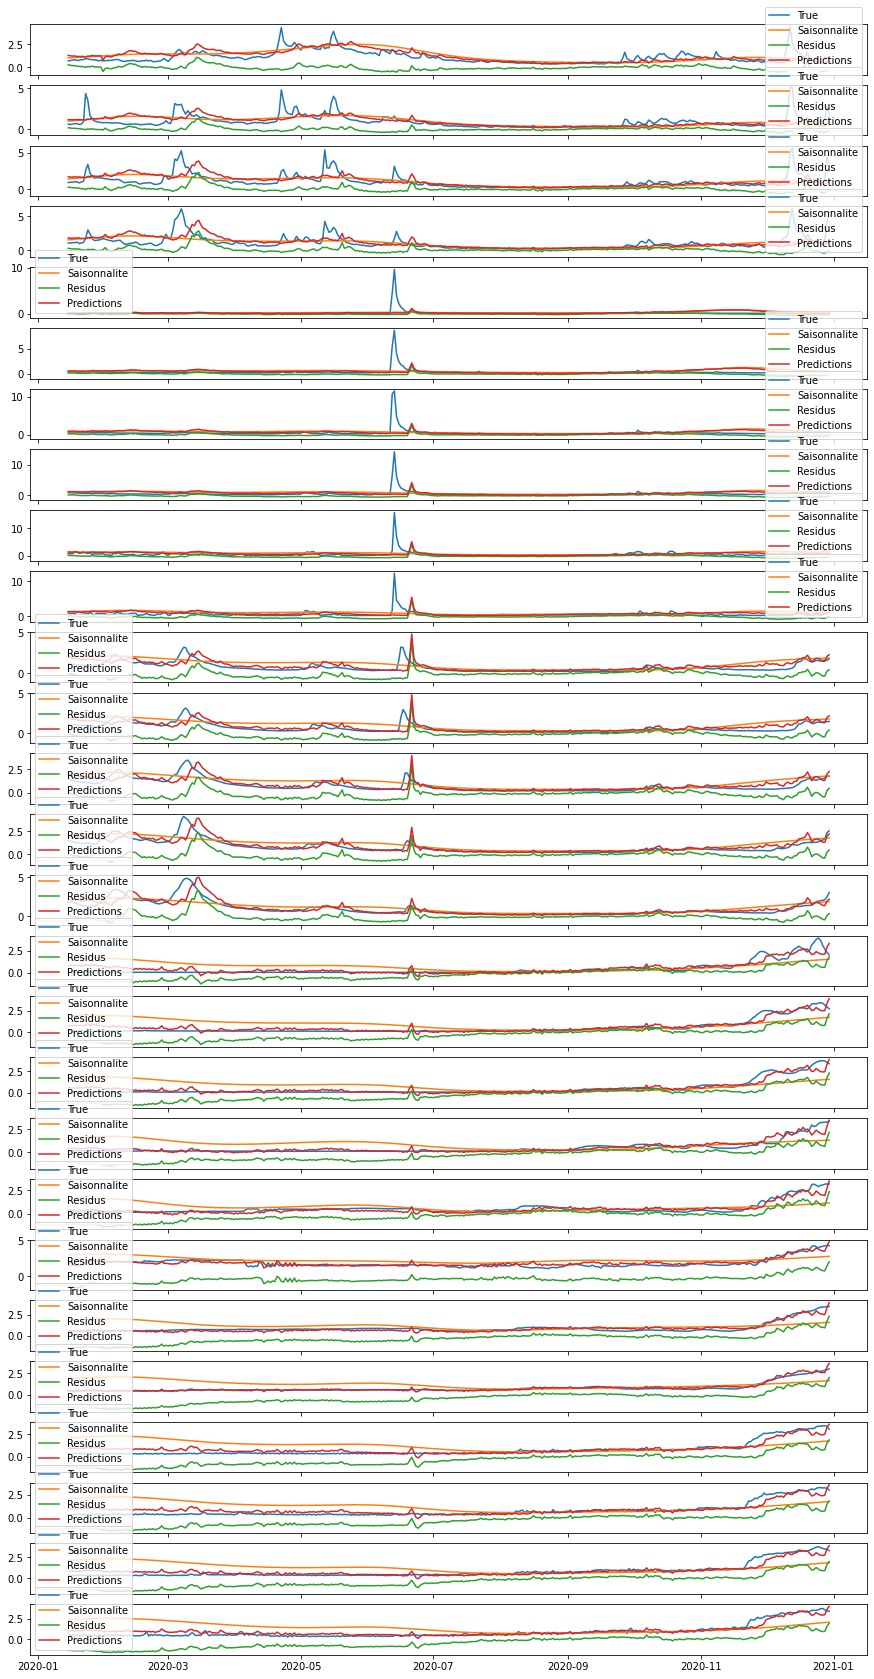

In [13]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard_saisonnalite["Date"], predictions_test_Y_standard_saisonnalite[code], label = "Saisonnalite")
    axs[i].plot(predictions_test_Y_standard_residus["Date"], predictions_test_Y_standard_residus[code], label = "Residus")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [14]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)

test_scores_standard = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.546325,0.390403,0.880420
1,O2620010,0.717816,0.448178,0.471614
2,O6140010,0.835751,0.522329,0.614925
3,O9000010,0.905617,0.541809,0.610478
4,K0030020,0.641675,0.203371,0.118081
5,K0100020,0.676710,0.322904,0.201462
6,K0260020,0.967947,0.421829,0.159142
7,K0550010,1.011386,0.457306,0.205548
8,K0690010,1.082166,0.512545,0.210687
9,K0910050,0.893057,0.479435,0.313254


In [15]:
test_scores_standard.to_csv("../Data/GAMGamma_VAR/Test_scores_standard.csv",
                   index = False)

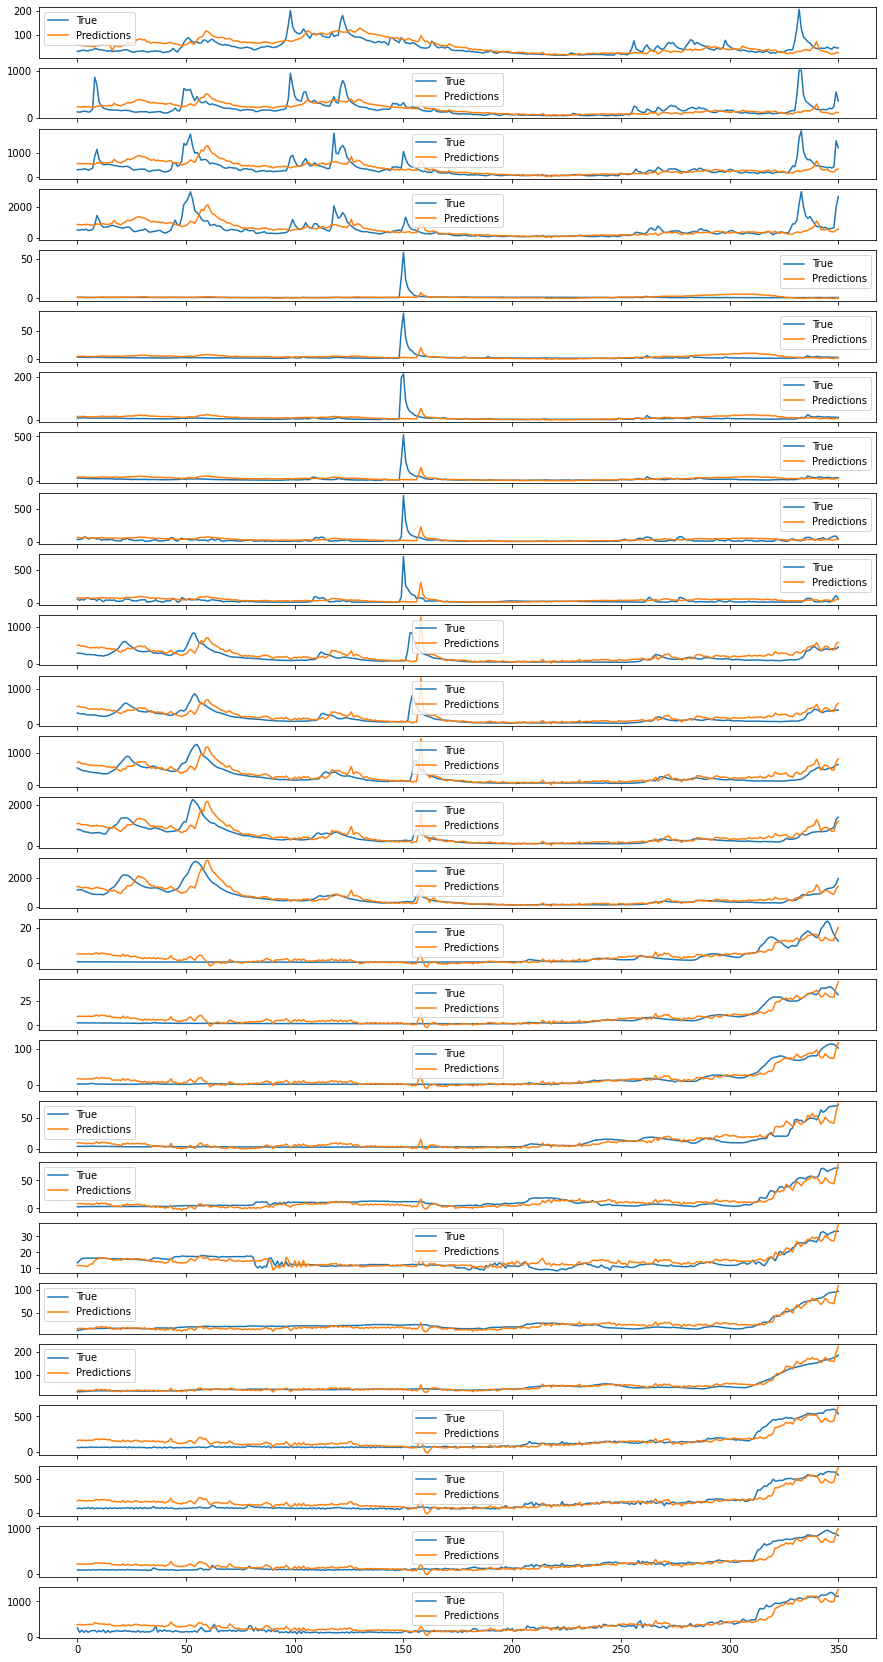

In [16]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [17]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations)

test_scores = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,25.361298,18.123165,0.880420
1,O2620010,142.281254,88.835154,0.471614
2,O6140010,274.996470,171.867641,0.614925
3,O9000010,440.324429,263.435933,0.610478
4,K0030020,3.935118,1.247189,0.118081
5,K0100020,6.371786,3.040412,0.201462
6,K0260020,17.930718,7.814164,0.159142
7,K0550010,36.847282,16.660791,0.205548
8,K0690010,48.412389,22.929527,0.210687
9,K0910050,51.567359,27.683777,0.313254


In [18]:
test_scores.to_csv("../Data/GAMGamma_VAR/Test_scores.csv",
                   index = False)